# 29. 전용면적과 target 사이에 이상치 탐지
- 전용면적이 300평 이상인 데이터에 대해서 가격이 너무 낮게 측정되어 있다.
- 실제 부동산 가격과 비교했을 때 2배 정도 작게 잡힌 것을 확인
- 강제로 2배로 만들어 줌

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import gc
from sklearn.preprocessing import MinMaxScaler

# 맥에서 글씨 깨짐 방지
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('../data/preprocessed/28_target_outlier.csv')

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_3906/2995280466.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/preprocessed/28_target_outlier.csv')


In [3]:
df.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0


In [4]:
train_df = df[df['is_test']==0]
test_df = df[df['is_test']==1]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x1500 with 0 Axes>

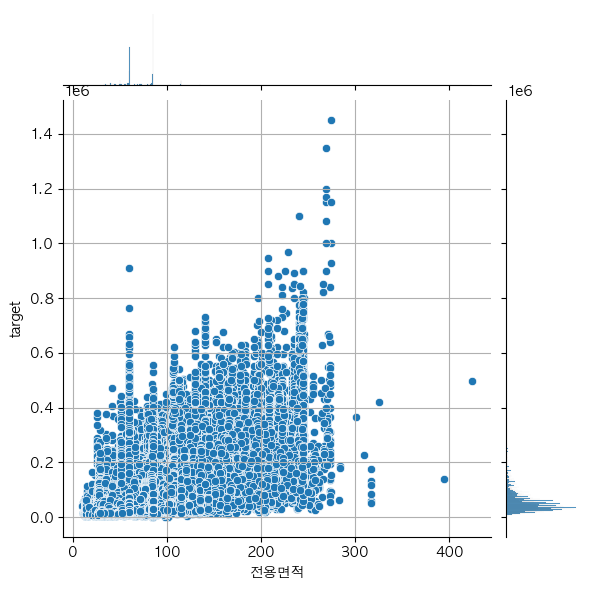

In [5]:
plt.figure(figsize=(15, 15))
sns.jointplot(x='전용면적', y='target', data=train_df)
plt.grid(True)
plt.show()

In [6]:
tmp = train_df[train_df['전용면적'] >= 300]
tmp

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
60088,서울특별시 서초구 서초동,1518-2,1518.0,2.0,월드빌라트,395.06,201809,28,10,1996,...,기타,2호선,서초구,기타,3342.873093,12.0,반포대교,0.0,0,8.0
196933,서울특별시 용산구 이촌동,302-69,302.0,69.0,정우,317.36,200904,7,3,1972,...,기타,경원선,용산구,기타,862.155013,9.0,한강대교,2.0,1,5.0
222996,서울특별시 중구 장충동1가,106-1,106.0,1.0,장충레지던스,309.70,202303,16,4,1993,...,기타,3호선,기타,기타,2885.110471,14.0,동호대교,0.0,0,5.0
223824,서울특별시 강남구 도곡동,467,467.0,0.0,타워팰리스1,301.47,202205,12,56,2002,...,기타,3호선,강남구,기타,4362.673070,17.0,청담대교,0.0,0,8.0
288524,서울특별시 용산구 이촌동,302-69,302.0,69.0,정우,317.36,202105,13,9,1972,...,기타,경원선,용산구,기타,862.155013,9.0,한강대교,2.0,1,5.0
381470,서울특별시 용산구 이촌동,302-69,302.0,69.0,정우,317.36,202007,4,2,1972,...,기타,경원선,용산구,기타,862.155013,9.0,한강대교,2.0,1,5.0
436690,서울특별시 용산구 이촌동,302-69,302.0,69.0,정우,317.36,201810,26,5,1972,...,기타,경원선,용산구,기타,862.155013,9.0,한강대교,2.0,1,5.0
547784,서울특별시 강남구 도곡동,193-1,193.0,1.0,힐데스하임빌라,424.32,201604,11,10,1998,...,기타,3호선,강남구,기타,4612.528856,17.0,청담대교,0.0,0,8.0
751298,서울특별시 용산구 이촌동,302-69,302.0,69.0,정우,317.36,201504,18,2,1972,...,기타,경원선,용산구,기타,862.155013,9.0,한강대교,2.0,1,5.0
751299,서울특별시 용산구 이촌동,302-69,302.0,69.0,정우,317.36,201509,15,7,1972,...,기타,경원선,용산구,기타,862.155013,9.0,한강대교,2.0,1,5.0


In [7]:
tmp[['아파트명', '좌표Y', '좌표X', '계약년월', '전용면적', 'target']]

,아파트명,좌표Y,좌표X,계약년월,전용면적,target
60088,월드빌라트,37.485490,127.005448,201809,395.06,137625.00000
196933,정우,37.520834,126.967175,200904,317.36,130000.00000
222996,장충레지던스,37.559495,127.007258,202303,309.70,228000.00000
223824,타워팰리스1,37.488223,127.054439,202205,301.47,366250.00000
288524,정우,37.520834,126.967175,202105,317.36,175000.00000
381470,정우,37.520834,126.967175,202007,317.36,58750.78125
436690,정우,37.520834,126.967175,201810,317.36,52506.25000
547784,힐데스하임빌라,37.488125,127.045027,201604,424.32,498000.00000
751298,정우,37.520834,126.967175,201504,317.36,85000.00000
751299,정우,37.520834,126.967175,201509,317.36,118000.00000


In [8]:
iloc_list = [60088, 196933, 222996, 288524, 381470, 751298, 751299]

for i in iloc_list:
    df.loc[i, 'target'] = df.loc[i, 'target']*2

In [9]:
train_df = df[df['is_test']==0]
train_df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0


In [10]:
train_df[train_df['전용면적'] >= 300][['아파트명', '계약년월', '층', 'target']]

,아파트명,계약년월,층,target
60088,월드빌라트,201809,10,275250.0000
196933,정우,200904,3,260000.0000
222996,장충레지던스,202303,4,456000.0000
223824,타워팰리스1,202205,56,366250.0000
288524,정우,202105,9,350000.0000
381470,정우,202007,2,117501.5625
436690,정우,201810,5,52506.2500
547784,힐데스하임빌라,201604,10,498000.0000
751298,정우,201504,2,170000.0000
751299,정우,201509,7,236000.0000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x1500 with 0 Axes>

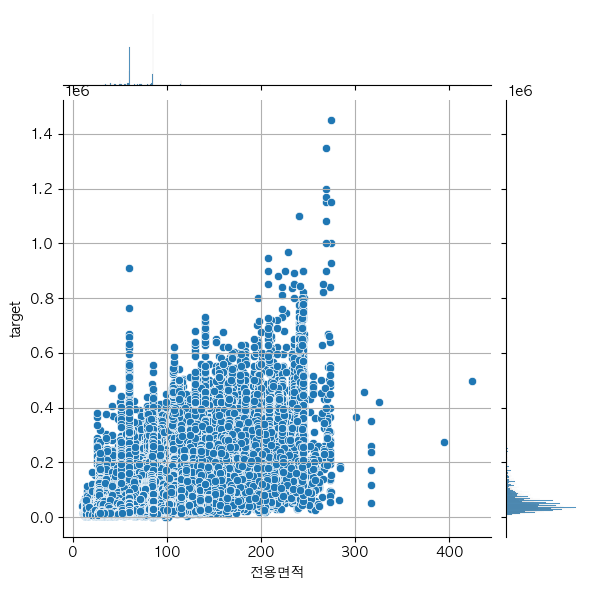

In [11]:
plt.figure(figsize=(15, 15))
sns.jointplot(x='전용면적', y='target', data=train_df)
plt.grid(True)
plt.show()

In [12]:
df.to_csv('../data/preprocessed/29_2_area_target_outlier.csv', index=False)